<a href="https://colab.research.google.com/github/hhc703/deep-learning/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

합성곱

In [ ]:
import numpy as np
w = np.array([2, 1, 5, 3])
x = np.array([2, 8, 3, 7, 1, 2, 0, 4, 5])

In [ ]:
w_r = np.flip(w) #배열을 뒤집어주는 함수
print(w_r)

[3 5 1 2]


In [ ]:
w_r = w[::-1] #위 함수 인덱싱 구현
print(w_r)

[3 5 1 2]


In [ ]:
for i in range(6):
  print(np.dot(x[i:i+4],w_r)) #합성곱

63
48
49
28
21
20


In [ ]:
from scipy.signal import convolve #사이파이 라이브러리의 합성곱 함수
convolve(x, w, mode = 'valid')

array([63, 48, 49, 28, 21, 20])

교차상관

In [ ]:
from scipy.signal import correlate #교차상관 함수
correlate(x, w, mode = 'valid') #밸리드 패딩

array([48, 57, 24, 25, 16, 39])

In [ ]:
correlate(x, w, mode = 'full') #풀 패딩

array([ 6, 34, 51, 48, 57, 24, 25, 16, 39, 29, 13, 10])

In [ ]:
correlate(w, x, mode = 'same') #세임 패딩

array([16, 25, 24, 57])

In [ ]:
x = np.array([[1, 2, 3],
              [4, 5, 6],
              [7, 8, 9]])
w = np.array([[2, 0],[0, 0]])
from scipy.signal import correlate2d
correlate2d(x, w, mode = 'valid')

array([[ 2,  4],
       [ 8, 10]])

In [ ]:
correlate2d(x, w, mode = 'same')

array([[ 2,  4,  6],
       [ 8, 10, 12],
       [14, 16, 18]])

In [ ]:
import tensorflow as tf
x_4d = x.astype(np.float).reshape(1, 3, 3, 1) #실수, 배열 변환
w_4d = w.reshape(2, 2, 1, 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


In [ ]:
c_out = tf.nn.conv2d(x_4d, w_4d, strides = 1, padding = 'SAME') #4차원 배열 전달

In [ ]:
c_out.numpy().reshape(3, 3)

array([[ 2.,  4.,  6.],
       [ 8., 10., 12.],
       [14., 16., 18.]])

풀링

In [ ]:
x = np.array([[1, 2, 3, 4],
              [5, 6, 7, 8],
              [9, 10, 11, 12],
              [13, 14, 15, 16]])
x = x.reshape(1, 4, 4, 1)

In [ ]:
p_out = tf.nn.max_pool2d(x, ksize = 2, strides = 2, padding = 'VALID') #최대 풀링
p_out.numpy().reshape(2, 2)

array([[ 6.,  8.],
       [14., 16.]], dtype=float32)

렐루 함수

In [ ]:
def relu(x): #렐루 함수
  return np.maximum(x, 0)

In [ ]:
x = np.array([-1, 2, -3, 4, -5])
relu(x)

array([0, 2, 0, 4, 0])

In [ ]:
r_out = tf.nn.relu(x) #tf 렐루 함수
r_out.numpy()

array([0, 2, 0, 4, 0])

합성곱 신경망

In [ ]:
class ConvolutionNetwork:

  def __init__(self, n_kernels = 10, units = 10, batch_size = 32, learning_rate = 0.1):
    self.n_kernels = n_kernels      # 합성곱의 커널 개수
    self.kernel_size = 3            # 커널 크기
    self.optimizer = None           # 옵티마이저
    self.conv_w = None              # 합성곱층의 가중치
    self.conv_b = None              # 합성곱층의 절편
    self.units = units              # 은닉층의 뉴런 개수 
    self.batch_size  = batch_size   # 배치 크기
    self.w1 = None                  # 은닉층의 가중치
    self.b1 = None                  # 은닉층의 절편
    self.w2 = None                  # 출력층의 가중치
    self.b2 = None                  # 출력층의 절편
    self.a1 = None                  # 은닉층의 활성화 출력
    self.losses = []                # 훈련 손실
    self.val_losses = []            # 검증 손실
    self.lr = learning_rate         # 학습률

  def forpass(self, x):
    # 3 x 3 합성곱 연산 수행
    c_out = tf.nn.conv2d(x, self.conv_w, strides = 1, padding = 'SAME') + self.conv_b
    # 렐루 함수 적용
    r_out = tf.nn.relu(c_out)
    # 2 x 2 최대 풀링 적용
    p_out = tf.nn.max_pool2d(r_out, ksize = 2, strides = 2, padding = 'VALID')
    # 첫 번째 배치 차원 제외하고 일렬로 펼침
    f_out = tf.reshape(p_out,[x.shape[0], -1])
    z1 = tf.matmul(f_out, self.w1) + self.b1  # 첫 번째 층의 선형식 계산
    a1 = tf.nn.relu(z1)                       # 활성화 함수 적용
    z2 = tf.matmul(a1, self.w2) + self.b2     # 두 번째 층의 선형식 계산
    return z2

  def init_weights(self, input_shape, n_classes):
    g = tf.initializers.glorot_uniform()
    self.conv_w = tf.Variable(g((3, 3, 1, self.n_kernels)))
    self.conv_b = tf.Variable(np.zeros(self.n_kernels), dtype = float)
    n_features = 14 * 14 * self.n_kernels
    self.w1 = tf.Variable(g((n_features, self.units)))          # (특성 개수, 은닉층의 크기)
    self.b1 = tf.Variable(np.zeros(self.units), dtype = float)  # 은닉층의 크기
    self.w2 = tf.Variable(g((self.units, n_classes)))           # (은닉층의 크기, 클래스 개수)
    self.b2 = tf.Variable(np.zeros(n_classes), dtype = float)   # 클래스 개수

  def fit(self, x, y, epochs = 100, x_val = None, y_val = None):
    self.init_weights(x.shape, y.shape[1]) # 은닉층과 출력층의 가중치 초기화
    self.optimizer = tf.optimizers.SGD(learning_rate=self.lr)
    # 에포크만큼 반복
    for i in range(epochs):
      print('에포크', i, end = ' ')
      # 제너레이터 함수에서 반환한 미니 배치 순환
      batch_losses = []
      for x_batch, y_batch in self.gen_batch(x, y):
        print('.', end='')
        self.training(x_batch, y_batch)
        # 배치 손실 기록
        batch_losses.append(self.get_loss(x_val, y_val))
      print( )
      # 배치 손실 평균 훈련 손실값으로 저장
      self.losses.append(np.mean(batch_losses))
      # 검증 세트에 대한 손실 계산
      self.val_losses.append(self.get_loss(x_val, y_val))  
  
  # 미니 배치 제너레이터 함수
  def gen_batch(self, x, y):
    bins = len(x) // self.batch_size                    # 미니 배치 횟수
    indexes = np.random.permutation(np.arange(len(x)))  # 인덱스를 섞는다
    x = x[indexes]
    y = y[indexes]
    for i in range(bins):
      start = self.batch_size * i
      end = self.batch_size * (i + 1)
      yield x[start:end], y[start:end]    # batch_size만큼 슬라이싱하여 반환

  def training(self, x, y):
    m = len(x)            # 샘플 갯수 저장
    with tf.GradientTape() as tape:
      z = self.forpass(x)
      # 손실 계산
      loss = tf.nn.softmax_cross_entropy_with_logits(y, z)
      loss = tf.reduce_mean(loss)
    
    weights_list = [self.conv_w, self.conv_b,
                    self.w1, self.b1, self.w2, self.b2]
    # 가중치에 대한 그레이디언트 계산
    grads = tape.gradient(loss, weights_list)
    # 가중치 업데이트
    self.optimizer.apply_gradients(zip(grads, weights_list))

  def predict(self, x):
    z = self.forpass(x)                    # 정방향 계산 수행
    return np.argmax(z.numpy(), axis = 1)  # 가장 큰 값의 인덱스 반환

  def score(self, x, y):
    # 예측과 타깃 열 벡터를 비교하여 true의 비율을 반환
    return np.mean(self.predict(x) == np.argmax(y, axis = 1))
      
  def get_loss(self, x, y):
    z = self.forpass(x) # 정방향 계산 수행
    # 손실을 계산하여 저장
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y, z))
    return loss.numpy()

자동 미분

In [ ]:
import tensorflow as tf
x = tf.Variable(np.array([1.0, 2.0, 3.0]))
with tf.GradientTape() as tape:
  y = x ** 3 + 2 * x + 5
print(tape.gradient(y, x))

tf.Tensor([ 5. 14. 29.], shape=(3,), dtype=float64)


합성곱 신경망 훈련

In [ ]:
(x_train_all, y_train_all),(x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

4431872/4422102 [==============================] - 0s 0us/step


In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all, stratify = y_train_all, test_size = 0.2, random_state = 42)

In [ ]:
y_train_encoded = tf.keras.utils.to_categorical(y_train)
y_val_encoded = tf.keras.utils.to_categorical(y_val)

In [ ]:
x_train = x_train.reshape(-1, 28, 28, 1)
x_val = x_val.reshape(-1, 28, 28, 1)

In [ ]:
x_train.shape

(48000, 28, 28, 1)

In [ ]:
x_train = x_train / 255
x_val = x_val / 255

In [ ]:
cn = ConvolutionNetwork(n_kernels=10, units=100, batch_size=128, learning_rate=0.01)
cn.fit(x_train, y_train_encoded, x_val=x_val, y_val=y_val_encoded, epochs=20)

에포크 0 ............

KeyboardInterrupt: ignored

케라스로 합성곱 신경망

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

In [ ]:
conv1 = tf.keras.Sequential()
conv1.add(Conv2D(10, (3, 3), activation='relu', padding='same', input_shape=(28, 28, 1)))

In [ ]:
conv1.add(MaxPooling2D(2, 2))

In [ ]:
conv1.add(Flatten())

In [ ]:
conv1.add(Dense(100, activation='relu'))
conv1.add(Dense(10, activation='softmax'))

In [ ]:
conv1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 10)        100       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 10)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 1960)              0         
                                                                 
 dense (Dense)               (None, 100)               196100    
                                                                 
 dense_1 (Dense)             (None, 10)                1010      
                                                                 
Total params: 197,210
Trainable params: 197,210
Non-trainable params: 0
__________________________________________________

In [ ]:
conv1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = conv1.fit(x_train, y_train_encoded, epochs=20, validation_data=(x_val, y_val_encoded))

Epoch 1/20
1500/1500 [==============================] - 26s 16ms/step - loss: 0.4599 - accuracy: 0.8384 - val_loss: 0.3568 - val_accuracy: 0.8691
Epoch 2/20
1500/1500 [==============================] - 21s 14ms/step - loss: 0.3171 - accuracy: 0.8860 - val_loss: 0.2942 - val_accuracy: 0.8947
Epoch 3/20
1500/1500 [==============================] - 21s 14ms/step - loss: 0.2667 - accuracy: 0.9020 - val_loss: 0.2722 - val_accuracy: 0.9028
Epoch 4/20
1500/1500 [==============================] - 21s 14ms/step - loss: 0.2339 - accuracy: 0.9138 - val_loss: 0.2747 - val_accuracy: 0.9024
Epoch 5/20
1500/1500 [==============================] - 22s 14ms/step - loss: 0.2078 - accuracy: 0.9224 - val_loss: 0.2574 - val_accuracy: 0.9077
Epoch 6/20
1500/1500 [==============================] - 21s 14ms/step - loss: 0.1858 - accuracy: 0.9306 - val_loss: 0.2482 - val_accuracy: 0.9101
Epoch 7/20
1500/1500 [==============================] - 21s 14ms/step - loss: 0.1672 - accuracy: 0.9367 - val_loss: 0.2598 -

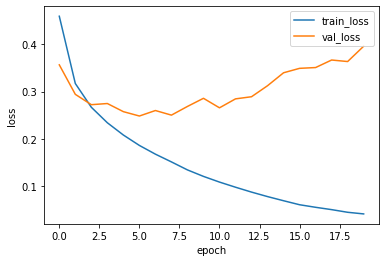

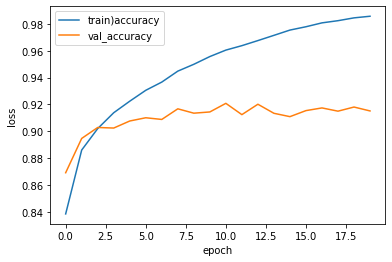

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train)accuracy', 'val_accuracy'])
plt.show()


In [ ]:
from tensorflow.keras.layers import Dropout

conv2 = tf.keras.Sequential()
conv2.add(Conv2D(10, (3, 3), activation='relu', padding='same', input_shape=(28, 28, 1)))
conv2.add(MaxPooling2D((2, 2)))
conv2.add(Flatten())
conv2.add(Dropout(0.5))
conv2.add(Dense(100, activation='relu'))
conv2.add(Dense(10, activation='softmax'))

In [ ]:
conv2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 28, 28, 10)        100       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 10)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 1960)              0         
                                                                 
 dropout (Dropout)           (None, 1960)              0         
                                                                 
 dense_2 (Dense)             (None, 100)               196100    
                                                                 
 dense_3 (Dense)             (None, 10)                1010      
                                                      

In [ ]:
conv2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = conv2.fit(x_train, y_train_encoded, epochs=20, validation_data=(x_val, y_val_encoded))

Epoch 1/20
1500/1500 [==============================] - 27s 17ms/step - loss: 0.5037 - accuracy: 0.8209 - val_loss: 0.3500 - val_accuracy: 0.8767
Epoch 2/20
1500/1500 [==============================] - 23s 16ms/step - loss: 0.3719 - accuracy: 0.8653 - val_loss: 0.3025 - val_accuracy: 0.8896
Epoch 3/20
1500/1500 [==============================] - 23s 16ms/step - loss: 0.3337 - accuracy: 0.8760 - val_loss: 0.2839 - val_accuracy: 0.8970
Epoch 4/20
1500/1500 [==============================] - 22s 15ms/step - loss: 0.3082 - accuracy: 0.8853 - val_loss: 0.2706 - val_accuracy: 0.9009
Epoch 5/20
1500/1500 [==============================] - 23s 15ms/step - loss: 0.2907 - accuracy: 0.8913 - val_loss: 0.2642 - val_accuracy: 0.9053
Epoch 6/20
1500/1500 [==============================] - 22s 15ms/step - loss: 0.2751 - accuracy: 0.8959 - val_loss: 0.2593 - val_accuracy: 0.9053
Epoch 7/20
1500/1500 [==============================] - 23s 16ms/step - loss: 0.2595 - accuracy: 0.9037 - val_loss: 0.2630 -

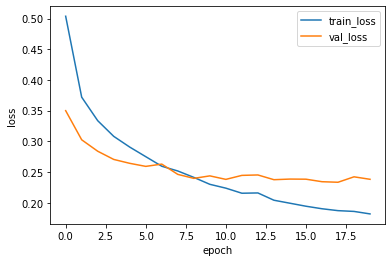

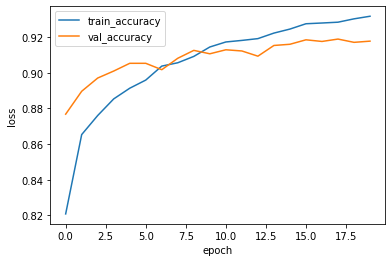

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()